##                                                  ***Exploración de dataframe accidentes - ETL***

Yearly how many planes crashed? how many people were on board? how many survived? how many died?
Highest number of crashes by operator and Type of aircrafts.
‘Summary’ field has the details about the crashes. Find the reasons of the crash and categorize them in different clusters i.e Fire, shot down, weather (for the ‘Blanks’ in the data category can be UNKNOWN) you are open to make clusters of your choice but they should not exceed 7.
Find the number of crashed aircrafts and number of deaths against each category from above step.
Find any interesting trends/behaviors that you encounter when you analyze the dataset.

In [1028]:
#IMPORTACIÓN DE LIBRERÍAS:
import pandas as pd
import numpy as np
import os
from unicodedata import normalize#para normalizar strings
import re #para normalizar incluyendo la ñ
import missingno as msno
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [1029]:
#DEFINO UNA FUNCION PARA LA CARGA  DATOS QUE CONTEMPLA DISTINTOS TIPOS DE ARCHIVO: DEVUELVE UN DATAFRAME 
def carga_datos (ruta):
    #CARGA DE DATOS Y EXTRACCIÓN DE FECHA:
    #limpio la ruta del atchivo dejando solo el nombre y la extensión
    tupla_archivos=os.path.split(ruta)
    #de la tupla que me devuelve la divido en el nombre que lo voy a usar como suministro en extensión
    nombre_tipo_archivo=tupla_archivos[1]
    #la segunda parte de la tupla es el tipo de archivo que es que lo uso para saber cómo ingestar
    extension_archivo= os.path.splitext(nombre_tipo_archivo)[-1]
    #detección de la manera de abrirlo en base a la extensión del archivo
    if extension_archivo==".json":
        #desde json
        df=pd.read_json(ruta)
    elif extension_archivo==".csv":
        #desde csv
        try:
            df=pd.read_csv(ruta,sep=",",encoding='utf-16',Index=True)
        except:
            df=pd.read_csv(ruta,sep=",",encoding='utf-8')
    elif extension_archivo==".xlsx":
        #desde un excel
        df=pd.read_excel(ruta,header=0)
        
    return df

In [1030]:
#Cargo el archivo y lo transformo en csv
crashes=carga_datos(r'C:\Users\Gise\Desktop\Data Since\LABS\Individuales\03\Mi poryecto\PI03-Analytics-main\PI03-Analytics-main\AccidentesAviones.csv')
crashes.head(3)

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...


##### ***1.1 Exploración inicial del dataframe accidentes***

*  ¿Qué forma tiene el dataset?

In [1031]:
crashes.shape

(5008, 18)

*  ¿Cuáles son sus columnas?

In [1032]:
crashes.columns

Index(['Unnamed: 0', 'fecha', 'HORA declarada', 'Ruta', 'OperadOR',
       'flight_no', 'route', 'ac_type', 'registration', 'cn_ln', 'all_aboard',
       'PASAJEROS A BORDO', 'crew_aboard', 'cantidad de fallecidos',
       'passenger_fatalities', 'crew_fatalities', 'ground', 'summary'],
      dtype='object')

*  ¿Qué tipos de valores tienen sus columnas? Son correctos? se pueden cambiar?

In [1033]:
crashes.dtypes

Unnamed: 0                 int64
fecha                     object
HORA declarada            object
Ruta                      object
OperadOR                  object
flight_no                 object
route                     object
ac_type                   object
registration              object
cn_ln                     object
all_aboard                object
PASAJEROS A BORDO         object
crew_aboard               object
cantidad de fallecidos    object
passenger_fatalities      object
crew_fatalities           object
ground                    object
summary                   object
dtype: object

Podemos empezar diciendo que:
*  Hay que pasar a formato fecha: fecha, hora declarada
*  Hay que pasar a número (str/float): cn_ln,	all_aboard,	PASAJEROS A BORDO,	crew_aboard	cantidad de fallecidos,	passenger_fatalities,	crew_fatalities	ground,


Mean
* Date - Date of accident
* Time - Local time, in 24 hr. in the format hh:mm
* Location - Location of the accident
* Operator - Airline or operator of the aircraft
* Flight - Flight number assigned by the aircraft operator
* Route - Complete or partial route flown prior to the accident
* Type - Aircraft type
* Registration - ICAO registration of the aircraft
* cn/In - Construction or serial number / Line or fuselage number
* Total Aboard - Total people aboard
* Passengers Aboard - Passengers aboard
* Crew Aboard - Crew aboard
* Total Fatalities - Total fatalities
* Passengers Fatalities - Passengers fatalities
* Crew Fatalities - Crew fatalities
* Ground - Total killed on the ground
* Summary - Brief description of the accident and cause if known

#### ***`2. ETL de accidentes`***

In [1034]:
# rename column names
crashes.columns=['delete','date', 'time', 'location', 'operator', 'flight', 'route', 'type', 
                  'registration', 'cn/ln', 'total_aboard', 'passengers_aboard', 
                  'crew_Aboard', 'total_fatalities', 'passengers_fatalities', 
                  'crew_Fatalities', 'ground', 'summary']

In [1035]:
crashes.head(4)

,delete,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...


##### ***2.1 Normalización de las palabras***

In [1036]:
#creamos una función para normalizar el índice
def normalizar_index(df):
    df.reset_index(drop = True, inplace = True)
    return(df)

In [1037]:
#Creamos una función de diagnóstico general para todo el dataset: Devuelve un dataframe diagnóstico de la tabla y el df ingestado con normalizaciones
def Estado_general_tabla (df):
    #Acomodamos el indice
    df=normalizar_index(df)
    #Vemos valores null
    nulos=df.isnull().sum().sum()
    print(nulos)
    #Vemos duplicados y existen los eliminamos
    duplicados=df.duplicated().sum().sum()
    if duplicados>0:
        print(duplicados)
        df.drop_duplicates(inplace = True)     

    #creamos listas vacías para guardar los valores que vayamos obteniendo del análisis de cada columna
    indice=0
    nombre_columna=[]
    tipo_de_dato=[]
    valores_null=[]
    cantidad_repetidos=[]
    cantidad_valores_unicos=[]
    valores_unicos=[]
    
    #recorremos cada columna del dataset con un bucle
    for c in df.columns:
        #vemos si la columna posee un volúmen de datos que sea analizable: se toma como criterio que tenga al menos un 1% de valores
        if df[c].isnull().sum()/(df[c].isnull().sum()+df[c].notnull().sum())>0.99:
            print("Se ha borrado la columna: ",c, "Por falta de datos")
            df.drop(c,axis=1,inplace=True)
        #si la columna tiene al menos un 1% de datos completos se continua el análisis
        else:
            #Agregamos el nombre de la columna a su lista correspondiente:
            nombre_columna.append(c)
            #detectamos el tipo de dato y lo agregamos a su lista correspondiente:
            tipo_de_dato.append(df[c].dtype)
                                     
            #Detectamos las columnas que son string 
            if df[c].dtype == 'object':
                #ponemos todo en minúsculas
                df[c]=df[c].str.lower() 
                df[c]=df[c].apply(lambda x:x.strip() if type(x)!=float else x)
                #creamos una lista de valores a reemplazar pero ahora no reemplazamos por espacio
                lista_simbolos=['!',',',';','-','.',' ?','? ','?',':']
                for elemento in lista_simbolos:
                    df[c]=df[c].apply(lambda x:x.replace(elemento ,'')if type(x)!=float else x)                  
                #creamos una lista de valores a reemplazar pero ahora no reemplazamos por espacio
                lista_simbolos=['_']
                for elemento in lista_simbolos:
                    df[c]=df[c].apply(lambda x:x.replace(elemento ,' ')if type(x)!=float else x)                  
            #sacamos los acentos
            df[c]=df[c].apply(lambda x: normalize( 'NFC', re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", x), 0, re.I))
                                            if type(x)== str and x!= 0 and x!= 'NaN'
                                            else x)
            #detectamos NaN
            df[c]=df[c].apply(lambda x: None if type(x)== str and x=='' else x)
            #Buscamos null y los agregamos a su lista correspondiente:
            valores_null.append(df[c].isnull().sum().sum())
                                
            # guargamos los valores repetidos
            cantidad_repetidos.append(df[c].duplicated().sum())
            
            #Buscamos valores diferentes (únicos) que existen:
            array_unicos=df[c].unique()
            #agregamos a la lista cantidad de valores únicos 
            cantidad_valores_unicos.append(len(array_unicos.ravel().tolist()))
            
            #Agregamos a la lista los valores únicos
            #sólo guardamos los primeros 10 valores
            if df[c].unique().shape[0]>10:
                valores_unicos.append(df[c].unique()[:10])
            #si no tienen 10 valores únicos nos agrega todos
            else:
                valores_unicos.append(df[c].unique())
            
            #Sumamos uno al índice para que continúe recorriendo las columnas
            indice+=1
    #creamos un df y vamos llenando sus columnas con las listas que hicimos previamente 
    df_resultado=pd.DataFrame()
    df.style.set_caption('Mi Tabla resumen')
    df_resultado["Nombre_columna"]=nombre_columna
    df_resultado["Tipo_de_dato"]=tipo_de_dato
    df_resultado["Cantidad_null"]=valores_null
    df_resultado['Cantidad_repetidos']=cantidad_repetidos
    df_resultado["cantidad_valores_unicos"]=cantidad_valores_unicos
    df_resultado["valores_unicos"]=valores_unicos
    #le colocamos un título a la tabla diagnóstico y la mostramos en pantalla
    display(df_resultado.style.set_caption('Mi Tabla resúmen'))
    #devolvemos el dataframe con las modificaciones standars realizadas
    return df

In [1038]:
Estado_general_tabla(crashes)

0


,Nombre_columna,Tipo_de_dato,Cantidad_null,Cantidad_repetidos,cantidad_valores_unicos,valores_unicos
0,delete,int64,0,0,5008,[0 1 2 3 4 5 6 7 8 9]
1,date,object,0,431,4577,['september 17 1908' 'september 07 1909' 'july 12 1912' 'august 06 1913' 'september 09 1913' 'october 17 1913' 'march 05 1915' 'september 03 1915' 'july 28 1916' 'september 24 1916']
2,time,object,1504,3903,1105,['1718' None '0630' '1830' '1030' '0100' '1520' '2345' '0515' '0845']
3,location,object,5,893,4115,['fort myer virginia' 'juvisysurorge france' 'atlantic city new jersey' 'victoria british columbia canada' 'over the north sea' 'near johannisthal germany' 'tienen belgium' 'off cuxhaven germany' 'near jambol bulgeria' 'billericay england']
4,operator,object,10,2767,2241,['military us army' None 'military us navy' 'private' 'military german navy' 'military german army' 'us aerial mail service' 'wingfoot air express goodyear tire' 'caproni company' 'aircraft transport and travel']
5,flight,object,3718,4120,888,[None 'faikg' '7' '599' '6' '4' '1' '14' '34' '23']
6,route,object,762,1181,3827,['demonstration' 'air show' 'test flight' None 'shuttle' 'venice taliedo' 'paris hounslow' 'washington newark' 'london paris' 'warsaw prague strasbourg paris']
7,type,object,13,2661,2347,['wright flyer iii' 'wright byplane' 'dirigible' 'curtiss seaplane' 'zeppelin l1 (airship)' 'zeppelin l2 (airship)' 'zeppelin l8 (airship)' 'zeppelin l10 (airship)' 'schuttelanz sl10 (airship)' 'zeppelin l32 (airship)']
8,registration,object,272,311,4697,[None 'sc1' 'l48' '97' '61' '82' '32' 'geahg' '77' 'geahf']
9,cn/ln,object,667,1104,3904,['1' None '77' '31' '20' '178' 'hp25' '57' 'r38' '160']


,delete,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
0,0,september 17 1908,1718,fort myer virginia,military us army,None,demonstration,wright flyer iii,None,1,2,1,1,1,1,0,0,during a demonstration flight a us army flyer ...
1,1,september 07 1909,None,juvisysurorge france,None,None,air show,wright byplane,sc1,None,1,0,1,1,0,0,0,eugene lefebvre was the first pilot to ever be...
2,2,july 12 1912,0630,atlantic city new jersey,military us navy,None,test flight,dirigible,None,None,5,0,5,5,0,5,0,first us dirigible akron exploded just offshor...
3,3,august 06 1913,None,victoria british columbia canada,private,None,None,curtiss seaplane,None,None,1,0,1,1,0,1,0,the first fatal airplane accident in canada oc...
4,4,september 09 1913,1830,over the north sea,military german navy,None,None,zeppelin l1 (airship),None,None,20,None,None,14,None,None,0,the airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,5003,march 28 2021,1835,near butte alaska,soloy helicopters,None,sightseeing charter,eurocopter as350b3 ecureuil,n351sh,4598,6,5,1,5,4,1,0,the sightseeing helicopter crashed after missi...
5004,5004,may 21 2021,1800,near kaduna nigeria,military nigerian air force,None,None,beechcraft b300 king air 350i,naf203,fl891,11,7,4,11,7,4,0,while on final approach in poor weather condit...
5005,5005,june 10 2021,0800,near pyin oo lwin myanmar,military myanmar air force,None,naypyidaw anisakan,beechcraft 1900d,4610,e325,14,12,2,12,11,1,0,the plane was carrying military personnel and ...
5006,5006,july 04 2021,1130,patikul sulu philippines,military philippine air force,None,cagayan de orolumbia jolo,lockheed c130h hercules,5125,5125,96,88,8,50,None,None,3,while attempting to land at jolo airport the m...


In [1039]:
crashes.flight[0]

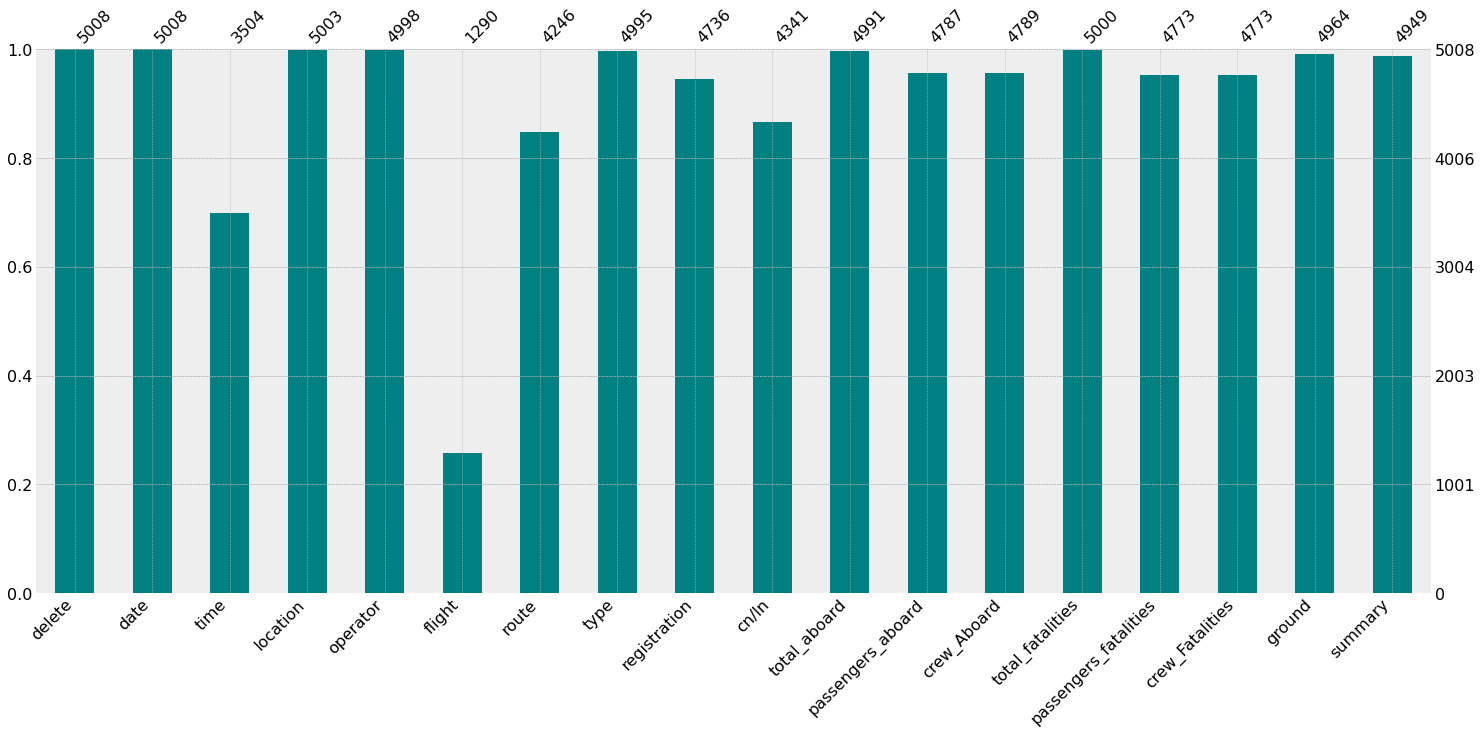

In [1040]:
#gráfico de completitud
msno.bar(crashes ,color="teal")
plt.show()

<AxesSubplot:>

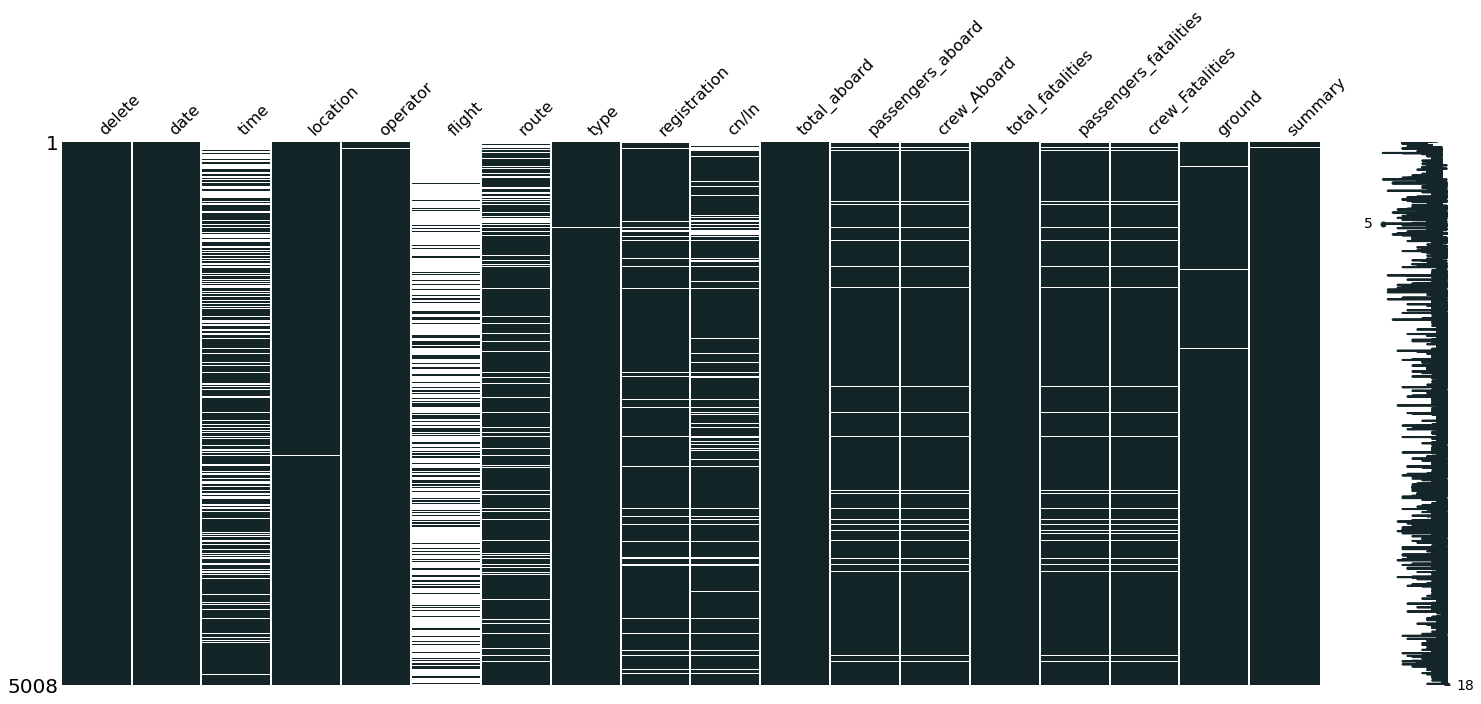

In [1041]:
msno.matrix(crashes, color=(0.08,0.149,0.159))

##### ***2.2 Exploración inicial de delete***

La columna unnamed es de valores únicos y va de 0 a shape.accidentes[0], por lo que es un índice y se prescindirá de la misma

In [1042]:
crashes.drop('delete', axis=1, inplace=True)

##### ***2.3 Exploración inicial de fecha***

In [1043]:
crashes.head(1)

,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
0,september 17 1908,1718,fort myer virginia,military us army,None,demonstration,wright flyer iii,None,1,2,1,1,1,1,0,0,during a demonstration flight a us army flyer ...


In [1044]:
def limpieza_fechas(df):
    #Acomodamos el indice
    df=normalizar_index(df)
    #df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%B %d %Y')if type(x)==str else x)
    #quito los espacios
    df['time']=df['time'].apply(lambda x: x.replace(' ','')if type(x)==str else x)

    df['time']=df['time'].apply(lambda x: x.replace('z','')if type(x)==str else x)
    
    pat = r"(\d+\.?\d)"
    a=df['time']
    df['time']=a.str.extract(pat, expand = False)
    #sólo tomo los últimos 4 dígitos de la cadena y le pongo puntos en el medio
    df['time']=df['time'].apply(lambda x: x[-4:-2]+':'+x[-2:] if x!= None else '00:00')

    #unimos ambas columnas
    df['time'] = df['date'] + ' ' + df['time'] 
    def todate(x):
        try: return datetime.datetime.strptime(x, '%B %d %Y %H:%M')
        except: 
            print(x)
            x='october 04 1992 00:00'
            return datetime.datetime.strptime(x, '%B %d %Y %H:%M')
    df['time'] = df['time'].apply(todate) #convert to date type
    print('Date ranges from ' + str(df.time.min()) + ' to ' + str(df.time.max()))   
    return df

In [1045]:
crashes=limpieza_fechas(crashes)

october 04 1992 1:75
Date ranges from 1908-09-17 17:18:00 to 2021-07-06 15:00:00


In [1046]:
crashes.loc[crashes.time=='october 04 1992 00:00']

,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
3794,october 04 1992,1992-10-04,amsterdam netherlands,el al,1862,amsterdam tel aviv,boeing b747258f,4xaxg,21737/362,4,1,3,4,1,3,39,shortly after taking off from schiphol airport...


In [1047]:
crashes.head(1)

,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
0,september 17 1908,1908-09-17 17:18:00,fort myer virginia,military us army,None,demonstration,wright flyer iii,None,1,2,1,1,1,1,0,0,during a demonstration flight a us army flyer ...


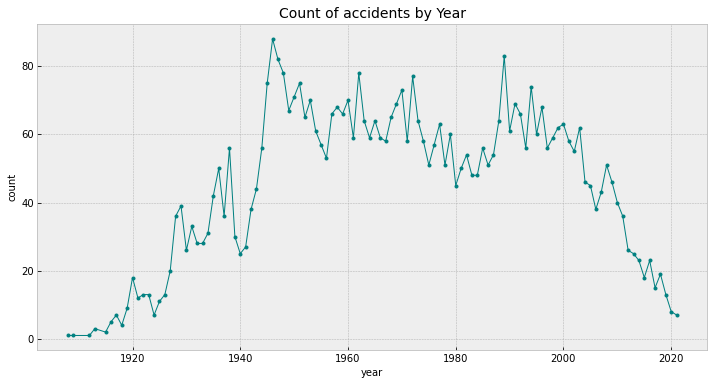

In [1048]:
Temp = crashes.groupby(crashes.time.dt.year)[['date']].count() #Temp is going to be temporary data frame 
Temp = Temp.rename(columns={"date": "count"})

plt.figure(figsize=(12,6))
plt.style.use('bmh')
plt.plot(Temp.index, 'count', data=Temp, color='teal', marker = ".", linewidth=1)
plt.xlabel('year', fontsize=10)
plt.ylabel('count', fontsize=10)
plt.title('Count of accidents by Year', loc='Center', fontsize=14)
plt.show()

c:\Users\Gise\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Gise\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Gise\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


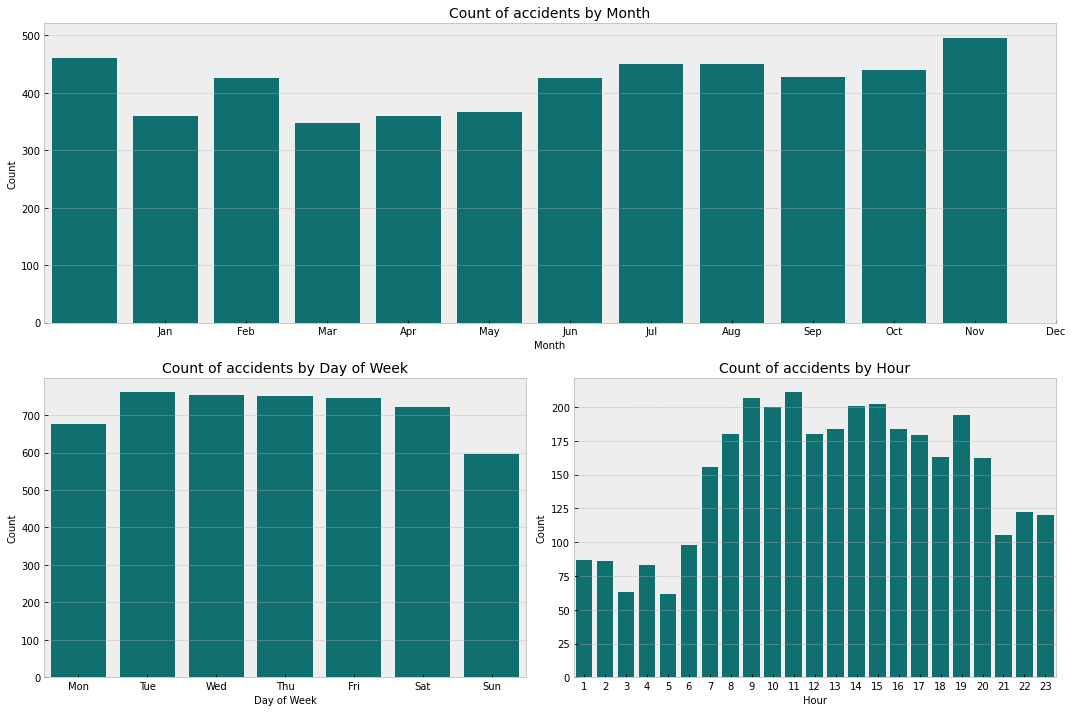

In [1049]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(15,10))
plt.style.use('seaborn-muted')
ax = pl.subplot(gs[0, :]) # row 0, col 0
sns.barplot(crashes.groupby(crashes.time.dt.month)[['date']].count().index, 'date', 
            data=crashes.groupby(crashes.time.dt.month)[['date']].count(), color='teal', linewidth=2)
plt.xticks(crashes.groupby(crashes.time.dt.month)[['date']].count().index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Month', loc='Center', fontsize=14)

ax = pl.subplot(gs[1, 0])
sns.barplot(crashes.groupby(crashes.time.dt.weekday)[['date']].count().index, 'date', 
            data=crashes.groupby(crashes.time.dt.weekday)[['date']].count(), color='teal', linewidth=2)
plt.xticks(crashes.groupby(crashes.time.dt.weekday)[['date']].count().index, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Day of Week', loc='Center', fontsize=14)

ax = pl.subplot(gs[1, 1])
sns.barplot(crashes[crashes.time.dt.hour != 0].groupby(crashes.time.dt.hour)[['date']].count().index, 'date',
            data=crashes[crashes.time.dt.hour != 0].groupby(crashes.time.dt.hour)[['date']].count(),color ='teal', linewidth=2)
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Hour', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

##### ***2.4 Exploración inicial de location***

In [1293]:
def location_transform (df):
    df["location"].fillna("Unknown", inplace=True)
    return df

In [1294]:
crashes=location_transform (crashes)

Intentaremos obtener las coordenadas del accidente

In [1295]:
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="sgisela945@gmail.com")
from time import sleep

In [1310]:
latitude=[]
longitude=[]

In [1311]:
'''for i,elemento in enumerate(crashes["location"]):
    try: 
        location = geolocator.geocode(crashes["location"][i]) 
        print(location.address) 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        print(crashes["location"][i]) 
        latitude.append(None)
        longitude.append(None)

    i+=1
    print(i)
    print('Go to sleep…')
    sleep(1)
    print('Back to work…')'''

North Fort Myer Drive, Rosslyn, Arlington, Arlington County, Virginia, 22209, United States
1
Go to sleep…
Back to work…
juvisysurorge france
2
Go to sleep…
Back to work…
Atlantic City, Atlantic County, New Jersey, 08401, United States
3
Go to sleep…
Back to work…
Victoria, Capital Regional District, British Columbia, Canada
4
Go to sleep…
Back to work…
over the north sea
5
Go to sleep…
Back to work…
near johannisthal germany
6
Go to sleep…
Back to work…
Tienen, Leuven, Vlaams-Brabant, Vlaanderen, 3300, België / Belgique / Belgien
7
Go to sleep…
Back to work…
off cuxhaven germany
8
Go to sleep…
Back to work…
near jambol bulgeria
9
Go to sleep…
Back to work…
Billericay, Basildon, Essex, England, United Kingdom
10
Go to sleep…
Back to work…
Potters Bar, Hertsmere, Hertfordshire, England, EN6 1QG, United Kingdom
11
Go to sleep…
Back to work…
Mainz, Rheinland-Pfalz, Deutschland
12
Go to sleep…
Back to work…
off west hartlepool england
13
Go to sleep…
Back to work…
near gent belgium
14
Go t

In [1313]:
coordenadas=pd.DataFrame()
coordenadas['lat']=latitude
coordenadas['long']=longitude
coordenadas.head()

In [1315]:
#coordenadas.to_csv('coordenadas.csv')

In [1400]:
coord=carga_datos(r'coordenadas.csv')
coord.columns=['Borrar','latitud','longitude']

In [1401]:
coord.drop('Borrar',axis=1,inplace=True)

In [1403]:
crashes=pd.concat([crashes, coord], axis=1)

In [1321]:
coord.dropna().shape

(2910, 3)

##### ***2.4 Exploración inicial de operator***

In [1059]:
crashes.operator.unique()

array(['military  us army', None, 'military  us navy', ...,
       'south sudan supreme airlines', 'soloy helicopters',
       'kamchatka aviation enterprise'], dtype=object)

In [1060]:
def limpiar_numeric_columns (df):
    lista=['total_aboard','passengers_aboard','crew_Aboard','total_fatalities','passengers_fatalities','crew_Fatalities','ground']
    for elemento in lista:
        df[elemento]=df[elemento].fillna('0')
        df[elemento]=df[elemento].astype('int32')
    return df

In [1061]:
crashes=limpiar_numeric_columns (crashes)

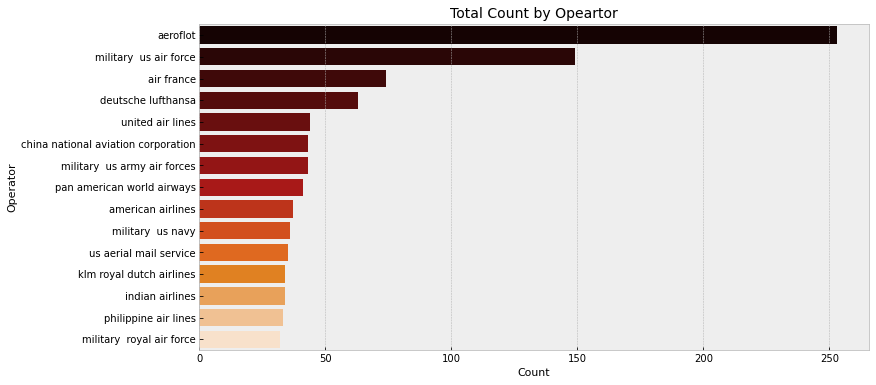

In [1062]:
crashes.operator = crashes.operator.replace('a b aerotransport', 'ab aerotransport')

Total_by_Op = crashes.groupby('operator')[['operator']].count()
Total_by_Op = Total_by_Op.rename(columns={"operator": "Count"})
Total_by_Op = Total_by_Op.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(y=Total_by_Op.index, x="Count", data=Total_by_Op, palette="gist_heat", orient='h')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

In [1063]:
crashes.groupby('operator')[['total_fatalities']].sum().sort_values(by='total_fatalities', ascending=False).head(15)

,total_fatalities
operator,
aeroflot,8802
military us air force,3481
air france,1798
american airlines,1422
pan american world airways,1303
military us army air forces,1070
united air lines,1019
avianca,951
turkish airlines (thy),890


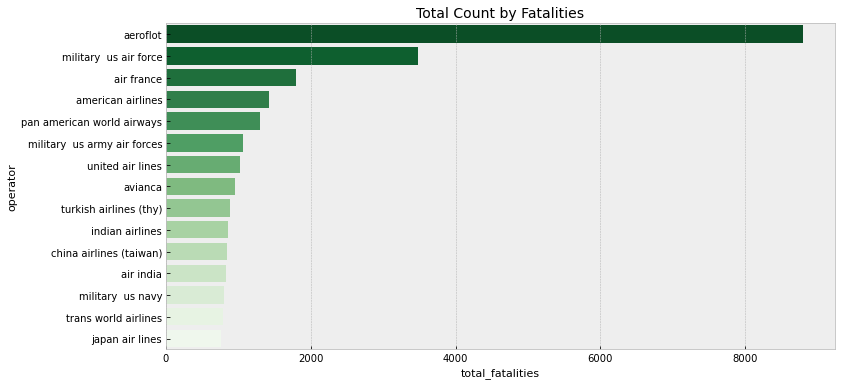

In [1415]:
Total_by_Op = crashes.groupby('operator')[['total_fatalities']].sum().sort_values(by='total_fatalities', ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(y=Total_by_Op.index, x='total_fatalities', data=Total_by_Op, palette="Greens_r", orient='h')
plt.xlabel('total_fatalities', fontsize=11)
plt.ylabel('operator', fontsize=11)
plt.title('Total Count by Fatalities', loc='Center', fontsize=14)
plt.show()

In [1065]:
#Vemos la catidad de muertes por accidente registrado
Total_by_Op = crashes.groupby('operator')[['total_fatalities']].sum().round(2)
Total_by_Op2 = crashes.groupby('operator')[['operator']].count()
Total_by_Op2 = Total_by_Op2.rename(columns={"operator": "Count"})
Total_by_Op2['Count']=Total_by_Op['total_fatalities']/Total_by_Op2['Count']

Total_by_Op2

,Count
operator,
46826/109,1.000000
aaxico airlines,3.000000
ab aerotransport,11.333333
ababeel aviaition,4.000000
abakan airlines,3.000000
...,...
ypfb transportes aereos,14.000000
zakavia,5.000000
zanex,1.000000


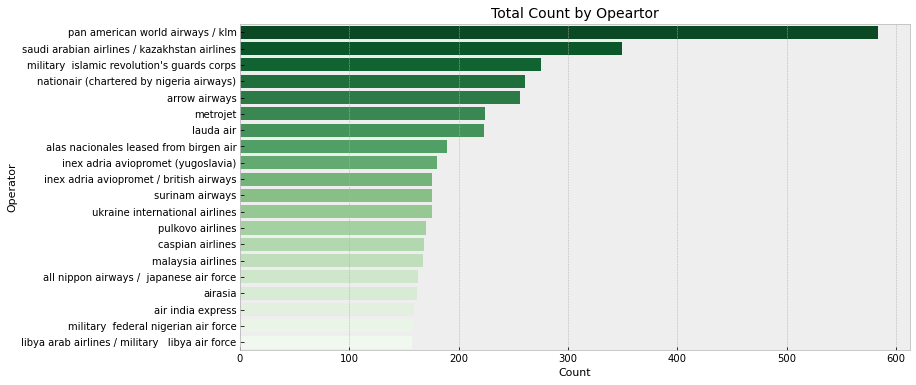

In [1416]:
Total_by_Op = Total_by_Op2.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(y=Total_by_Op.index, x="Count", data=Total_by_Op, palette="Greens_r", orient='h')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

Significa que el operario southwest mata a tres personas por cada vuelo registrado

***Veamos los vuelos que son militares y los que no***

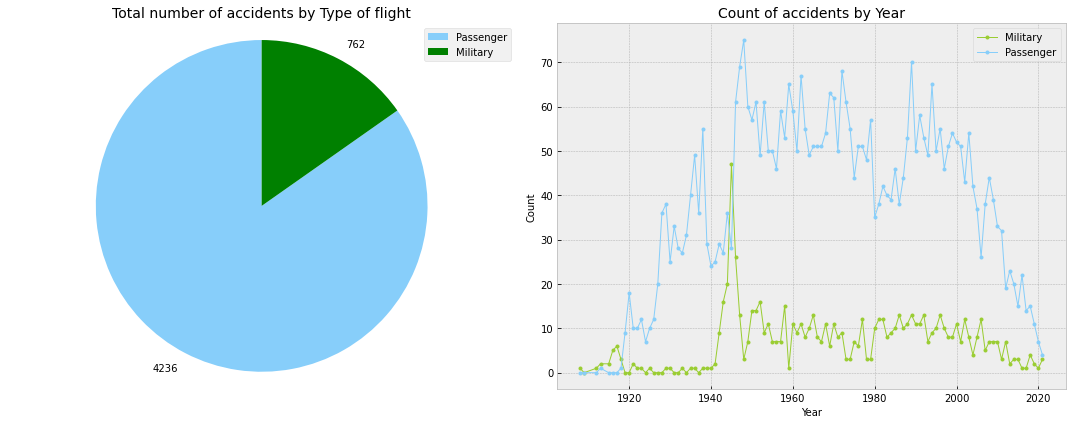

In [1422]:
Temp = crashes.copy()
Temp['isMilitary'] = Temp.operator.str.contains('military')
Temp = Temp.groupby('isMilitary')[['isMilitary']].count()
Temp.index = ['Passenger', 'Military']

Temp2 = crashes.copy()
Temp2['Military'] = Temp2.operator.str.contains('military')
Temp2['Passenger'] = Temp2.Military == False
Temp2 = Temp2.loc[:, ['time', 'Military', 'Passenger']]
Temp2 = Temp2.groupby(Temp2.time.dt.year)[['Military', 'Passenger']].aggregate(np.count_nonzero)

colors = ['lightskyblue', 'green']
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
patches, texts = plt.pie(Temp.isMilitary, colors=colors, labels=Temp.isMilitary, startangle=90)
plt.legend(patches, Temp.index, loc="best", fontsize=10)
plt.axis('equal')
plt.title('Total number of accidents by Type of flight', loc='Center', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(Temp2.index, 'Military', data=Temp2, color='yellowgreen', marker = ".", linewidth=1)
plt.plot(Temp2.index, 'Passenger', data=Temp2, color='lightskyblue', marker = ".", linewidth=1)
plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

##### ***2.4 Exploración inicial de flight***

In [1067]:
crashes.flight.unique()

array([None, 'faikg', '7', '599', '6', '4', '1', '14', '34', '23', '15a',
       'lz 129', '2', '8', '9', '229', '19', '16', '21', '3', '203', '5',
       '71', '7208', '28', 'v1104', '9035', '777', '63', '218', '13',
       '161', '6001', '142', '45', '216', '42', '105', '16b', '6103',
       '513', '878', '850', '942', '404', '44', '115', '140', '48',
       '6963', '2207', '665', '521', '605', '410', '121', '311', '608',
       '1629', '923', '10', '009', '572', '611', '700', '4422', '110',
       '624', '343', '072', '421', '331', '060', '6427', '100', '897r',
       '557', '118', '537', '157', '500', '307', '2501', '903', '32',
       '245', '83', '493', '129', '151', '610', '615', 'cam5763', '442',
       '501', '324', '6780', '101', '526a', '416w', '202', '251', '201',
       '376', '841', '166a', '470', '162', '636', '783/057', '318', '18',
       '512', '723', '627', '783', '304/44', '270', '781', '314', '152',
       '971', '633', '136', '57', '792', '451', '4844c', '329', '2

In [1405]:
def limpar_flight (df): 
    pat = (r"(\d+\.?\d)",r"(\d\d)",r"(\d)")
    a=df['flight']
    df['flight']=a.str.extract(pat, expand = False)
    return df

In [1406]:
df=crashes.copy()
limpar_flight (df)

TypeError: first argument must be string or compiled pattern

##### ***2.4 Exploración inicial de 'total_aboard','passengers_aboard','crew_Aboard','total_fatalities','passengers_fatalities','crew_Fatalities','ground'***

In [1070]:
crashes.describe()

,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground
count,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000
mean,31.015575,25.691294,4.321885,22.258387,18.051917,3.418930,1.703275
std,45.438768,43.405075,3.789422,34.983747,33.496574,3.193296,55.251400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,2.000000,4.000000,0.000000,1.000000,0.000000
50%,16.000000,11.000000,3.000000,11.000000,7.000000,3.000000,0.000000
75%,34.250000,29.000000,6.000000,25.000000,20.000000,5.000000,0.000000
max,644.000000,614.000000,83.000000,583.000000,560.000000,43.000000,2750.000000


##### ***2.4 Exploración inicial de summary***

In [1356]:
crashes.tail(2)

,date,time,location,operator,flight,route,type,registration,cn/ln,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,summary
5006,july 04 2021,2021-07-04 11:30:00,patikul sulu philippines,military philippine air force,None,cagayan de orolumbia jolo,lockheed c130h hercules,5125,5125,96,88,8,50,0,0,3,while attempting to land at jolo airport the m...
5007,july 06 2021,2021-07-06 15:00:00,palana russia,kamchatka aviation enterprise,251,petropavlovsk palana,antonov an 26b100,ra26085,12310,28,22,6,28,22,6,0,the passenger plane crashed into the top of a ...


In [1357]:
# Traemos las stopwords: palabras que no hacen a la significancia de la oración
import nltk
#inglés:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
#Sacar del texto carácteres que no sean palabras
# Importamos esta libreria que nos permite reemplzar caracteres
import re
# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [1423]:
dataset_fallecimientos =crashes[crashes.summary.notna()]
dataset_fallecimientos=normalizar_index(dataset_fallecimientos)
todos_titulares_fallecimientos = []
for index,i in enumerate(dataset_fallecimientos.summary):
    #guardamos la fila
    titular = dataset_fallecimientos.summary[index]
    #tokenizamos
    try: 
        titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
        #sacamos las stopwords
        titular = [word for word in titular if word not in stopwords]
        filtrar=['city','de','los','crashed','crew','plane','aircraft']
        titular = [word for word in titular if word not in filtrar]
        #los agredamos a la lista
        for word in titular:
            todos_titulares_fallecimientos.append(word)
    except:continue

freq_fallec = nltk.FreqDist(todos_titulares_fallecimientos)
#creo un df
df_fallec = pd.DataFrame(list(freq_fallec.items()), columns = ["Word","Frequency"])
#ordeno las palabras según la frequencia en orden descendente
df_fallec.sort_values('Frequency',ascending=False, inplace = True)
#restituyo los índices
df_fallec.reset_index(drop = True, inplace=True)
df_fallec.head(10)

,Word,Frequency
0,flight,1121
1,pilot,1117
2,runway,1035
3,engine,1004
4,approach,978
5,failure,855
6,airport,788
7,landing,787
8,altitude,650
9,weather,637


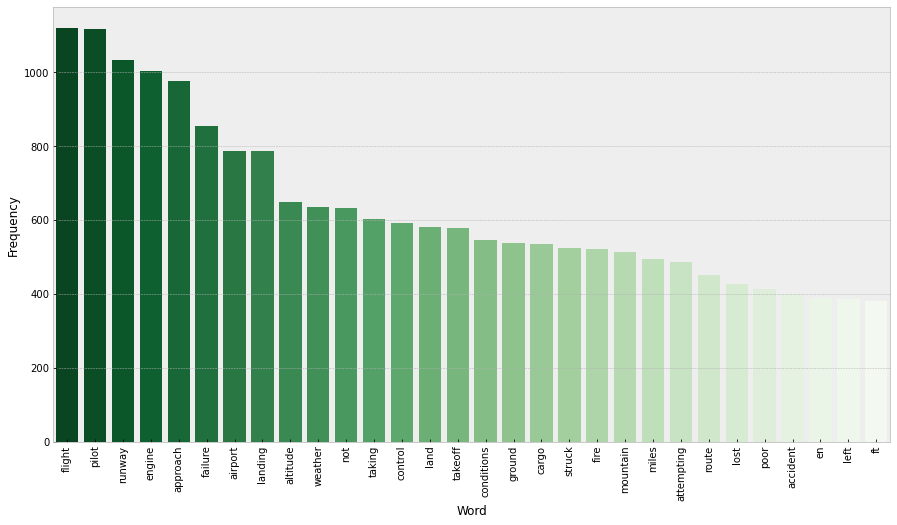

In [1424]:
#grafico un diagrama de columnas con las palabras y las frecuencias de aparición
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_fallec.iloc[:30].Word, y = df_fallec.iloc[:30].Frequency,palette='Greens_r')
#etiquetas a 90°
for item in plot.get_xticklabels(): item.set_rotation(90)
plt.show()

##### ***2.4 Exploración inicial de route***

In [1425]:
dataset_fallecimientos =crashes[crashes.route.notna()]
dataset_fallecimientos=normalizar_index(dataset_fallecimientos)
todos_titulares_fallecimientos = []
for index,i in enumerate(dataset_fallecimientos.route):
    #guardamos la fila
    titular = dataset_fallecimientos.route[index]
    #tokenizamos
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    #sacamos las stopwords
    titular = [word for word in titular if word not in stopwords]
    filtrar=['city','de','los','la','ca','st']
    titular = [word for word in titular if word not in filtrar]
    #los agredamos a la lista
    for word in titular:
        todos_titulares_fallecimientos.append(word)
freq_fallec = nltk.FreqDist(todos_titulares_fallecimientos)
#creo un df
df_fallec = pd.DataFrame(list(freq_fallec.items()), columns = ["Word","Frequency"])
#ordeno las palabras según la frequencia en orden descendente
df_fallec.sort_values('Frequency',ascending=False, inplace = True)
#restituyo los índices
df_fallec.reset_index(drop = True, inplace=True)
df_fallec.head(10)

,Word,Frequency
0,new,149
1,san,140
2,york,117
3,paris,116
4,training,104
5,london,88
6,moscow,84
7,chicago,75
8,rome,74
9,rio,70


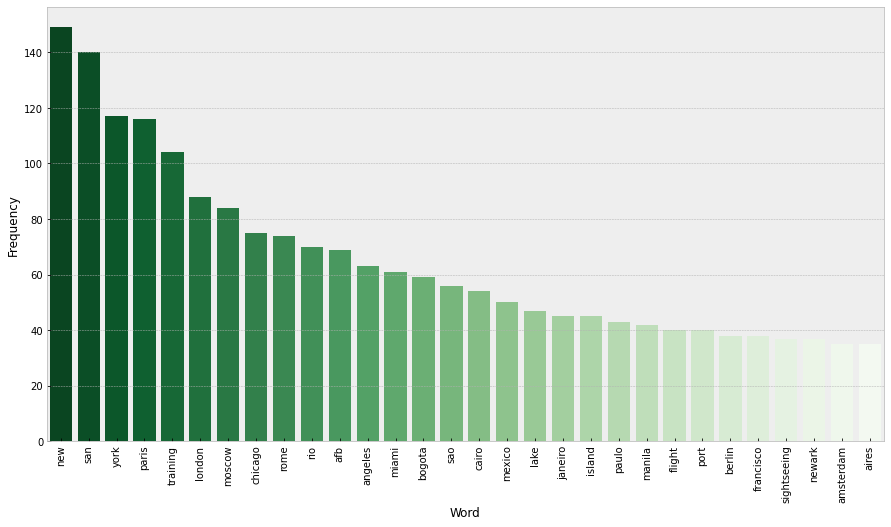

In [1426]:
#grafico un diagrama de columnas con las palabras y las frecuencias de aparición
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_fallec.iloc[:30].Word, y = df_fallec.iloc[:30].Frequency,palette='Greens_r')
#etiquetas a 90°
for item in plot.get_xticklabels(): item.set_rotation(90)
plt.show()

#### ***`3. Información extra`***

Elegimos un dataset donde se ven la cantidad de vuelos totales según el año en el rando de 1970 a 2016

From https://data.worldbank.org/indicator/IS.AIR.DPRT?end=2016&start=1970&view=chart

In [1453]:
totals=carga_datos(r'C:\Users\Gise\Desktop\Data Since\LABS\Individuales\03\Mi poryecto\Extra information\API_IS.AIR.DPRT_DS2_en_csv_v2_4536741.csv')
totals.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2132.0,2276.000000,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,548834.772,534810.303494,556341.0,562927.0,630147.0,705127.484622,717795.3,298383.68085,NaN,NaN
2,Afghanistan,AFG,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,21696.000,25920.000000,23532.0,22770.0,24207.0,10454.000000,7334.0,4635.71400,NaN,NaN


In [1454]:
#Ver la cantidad de filas
totals.shape[0]

266

In [1457]:
#Ver los primeros 50 paises diferentes
totals['Country Name'].unique()[:50]

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states'], dtype=object)

Data Cleaning and Manipulation

In [1458]:
#Eliminamos las columnas que no nos son útiles
totals = totals.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis = 1)
#Reemplazo los null con 0
totals = totals.replace(np.nan, 0)
#sumo todas las filas para que me de una sola con la suma de todos los paises
totals = pd.DataFrame(totals.sum())
#Elijo solo el rango de columnas en las que tienen los mismos años que mi dataset crashes
totals = totals.drop(totals.index[0:10])
#Las transformo a filas
totals = totals['1970':'2008']
#Creo una columna suma
totals.columns = ['Sum']
#pongo como índice el año
totals.index.name = 'Year'
totals.head()

,Sum
Year,
1970,57172800.0
1971,57470500.0
1972,48246800.0
1973,59097600.0
1974,64820200.0


In [1459]:
#Usando mi dataset original creo un nevo dataset (que es el que exportare a powerbi)
#agrupo por año los accidentes
Fatalities = crashes.groupby(crashes.time.dt.year).sum()
#borro las columnas de latitud y longitud
Fatalities = Fatalities.drop(['latitud','longitude'],axis=1)
#reestablezco el índice (luego de agruparlo se ha dañado)
Fatalities = Fatalities.reset_index()
#Conviero a str la columna time
Fatalities.time = Fatalities.time.apply(str)
#convierto los años en ínidice
Fatalities.index = Fatalities['time']
#borro la columna time para que no quede duplicada
del Fatalities['time']
#acoto los rango de fechas a los que conseguí en el otro dataset de vuelos totales
Fatalities = Fatalities['1970':'2008']
#Fatalities = Fatalities[['Fatalities']]
#concateno los dos dataset
Totals = pd.concat([totals, Fatalities], axis=1) #joining two data frames into one
Totals.head()

,Sum,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground
1970,57172800.0,2618,2208,368,1920,1570,283,9
1971,57470500.0,2422,2132,290,1784,1561,222,0
1972,48246800.0,3471,2960,366,2796,2422,305,54
1973,59097600.0,3325,2934,374,2323,2032,276,16
1974,64820200.0,2878,2592,286,2242,2213,221,0


In [1460]:
#Calculamos el porcentaje de muertes sobre el total de vuelos
Totals['Ratio'] = Totals['total_fatalities'] / Totals['Sum'] * 100 

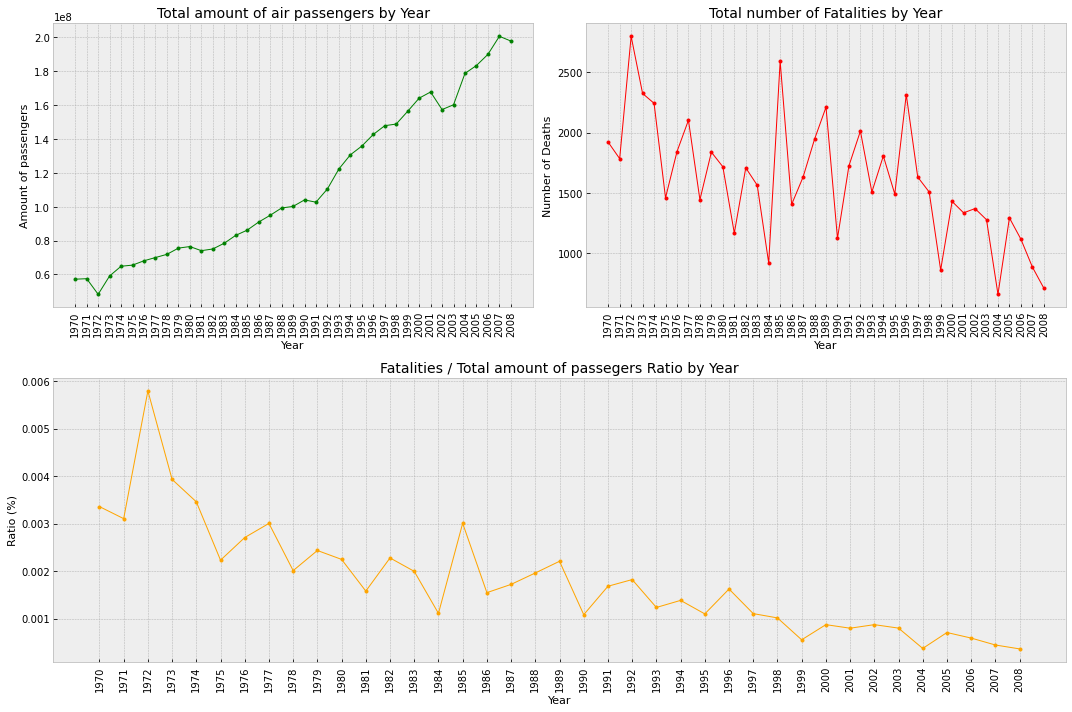

In [1461]:
#Plotiamos los resultados obtenidos
gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(15,10))
#Primero los vuelos por año del nuevo dataset
ax = pl.subplot(gs[0, 0]) 
plt.plot(totals.index, 'Sum', data=Totals, marker = ".", color = 'green', linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Amount of passengers', fontsize=11)
plt.title('Total amount of air passengers by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)
#luelo los fallecimientos por año
ax = pl.subplot(gs[0, 1]) 
plt.plot(Fatalities.index, 'total_fatalities', data=Fatalities, color='red', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Number of Deaths', fontsize=11)
plt.title('Total number of Fatalities by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)
#Finalmente la relación entre muertes/ vuelo en porcetaje
ax = pl.subplot(gs[1, :]) 
plt.plot(totals.index, 'Ratio', data=Totals, color='orange', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Ratio (%)', fontsize=11)
plt.title('Fatalities / Total amount of passegers Ratio by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [1462]:
Totals.head()

,Sum,total_aboard,passengers_aboard,crew_Aboard,total_fatalities,passengers_fatalities,crew_Fatalities,ground,Ratio
1970,57172800.0,2618,2208,368,1920,1570,283,9,0.003358
1971,57470500.0,2422,2132,290,1784,1561,222,0,0.003104
1972,48246800.0,3471,2960,366,2796,2422,305,54,0.005795
1973,59097600.0,3325,2934,374,2323,2032,276,16,0.003931
1974,64820200.0,2878,2592,286,2242,2213,221,0,0.003459


Sugerimos ver los siguientes enlaces para seguir enriqueciendo la información:
* https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FMD&QO_fu146_anzr=Nv4%20Pn44vr4%20Sv0n0pvny
* https://datos.estadisticas.pr/dataset/estadisticas-de-las-companias-aereas

#### ***`4. Send to MySQL`***

In [1085]:
from sqlalchemy import create_engine
import pyodbc
import os

In [1086]:
#creamos conexión con MySQL
cadena_conexion="mysql+pymysql://root@127.0.0.1:3306/labs_individual_03"
conexion=create_engine(cadena_conexion)

In [1404]:
#pasamos a mysql la tabla de crashes
crashes.to_sql(name="crashes",con=conexion,if_exists="replace",index=False)

5008

In [1465]:
#pasamos a mysql la tabla de info complementaria
Totals.to_sql(name="total_de_vuelos",con=conexion,if_exists="replace",index=False)

39